<a href="https://colab.research.google.com/github/GruAna/VU/blob/master/Copy_of_keras_ocr_born_digital_public_tuning_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning recognizer with keras-ocr

This is an interactive example of the code documented in https://keras-ocr.readthedocs.io/en/latest/examples/fine_tuning_recognizer.html

In [1]:
!pip install -U git+https://github.com/faustomorales/keras-ocr.git#egg=keras-ocr
!pip install imgaug==0.2.9
!pip install -U opencv-python # We need the most recent version of OpenCV.
%tensorflow_version 2.x

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/faustomorales/keras-ocr.git to /tmp/pip-install-oe9yo_5i/keras-ocr_6429fc9108574f44bdda44d76d7edad3
  Running command git clone -q https://github.com/faustomorales/keras-ocr.git /tmp/pip-install-oe9yo_5i/keras-ocr_6429fc9108574f44bdda44d76d7edad3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 604 kB 29.0 MB/s 
     |████████████████████████████████| 930 kB 62.4 MB/s 
     |████████████████████████████████| 9.5 MB 53.6 MB/s 
     |████████████████████████████████| 50 kB 8.4 MB/s 
  Created wheel for keras-ocr: filename=keras_ocr-0.9.0.post2+40bb9bd-py3-none-any.whl size=42441 sha256=395ed38f34cb967c37e2cf7ce5f322a5231d7070ae68addf74cc2ca4a5851340
  Stored in directory: /tmp/pip-ephem-wheel-cache-a_u7b8h8/wheels/20/d0/06/ed290995144ec8dde71d3a91

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/Colab_Notebooks/VU/utils.py /content

Mounted at /content/drive


In [3]:
from utils import *

In [4]:
import random
import string
import math
import itertools
import os
import cv2 as cv

import numpy as np
import imgaug
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

import keras_ocr

assert tf.config.list_physical_devices('GPU')

This example shows how to fine-tune the recognizer using an existing dataset. In this case,
we will use the "Born Digital" dataset from https://rrc.cvc.uab.es/?ch=1&com=downloads

First, we download our dataset. Below we get both the training and test datasets, but
we only use the training dataset. The training dataset consists of a single folder
containing images, each of which has a single word in it. The labels are in a text
file called `gt.txt`.

## Dataset loading (training data)

**CTW1500 dataset**

Get images. Update location of images **manually**.

In [90]:
# path to image directory, get full path to all files
imgs_dir = '/content/drive/MyDrive/Colab_Notebooks/VU/CTW1500/train_images'
(_, _, filenames) = next(os.walk(imgs_dir))
filenames.sort()
list_img_paths = [os.path.join(imgs_dir, file) for file in filenames]
n_imgs = len(list_img_paths)

# load images
train_images = [(cv.imread(file)) for file in list_img_paths]

# path to label directory, get full path to all files
labels_dir = '/content/drive/MyDrive/Colab_Notebooks/VU/CTW1500/ctw1500_train_labels'
(_, _, xml_files) = next(os.walk(labels_dir))
xml_files.sort()
list_xml_paths = [os.path.join(labels_dir, file) for file in xml_files]



Get ground truths from all xml files

In [93]:
ground_truth = []

for i, file in enumerate(list_xml_paths):
     ground_truth.append(read_gt_ctw_train(file))

# ground_truth is in the is a list of tuples, where first is the gt word 
# and second is an array of top left and bottom right coordinates
# format: ('text', [[tl,tl],[br,br]])

In [113]:
cropped_gt = image_text_crop(train_images, filenames, ground_truth,  result_folder='./train_data', skip_longer_than=40)
train_dir = '/content/train_data/'
(_, _, train_files) = next(os.walk(train_dir))
train_files = [os.path.join(train_dir, file) for file in sorted(train_files)]

1000it [00:12, 81.08it/s]


In [117]:
train_labels = [
    (filepath, None, "".join(
        char for char in word.split('\t',1)[1].lower() if (char.isalnum() or char.isspace()))) 
    for filepath, word in list(zip(train_files, cropped_gt))
    ]

We next build our recognizer, using the default options to get a pretrained model.

In [124]:
recognizer = keras_ocr.recognition.Recognizer()
recognizer.compile()

Looking for /root/.keras-ocr/crnn_kurapan.h5


We need to convert our dataset into the format that :code:`keras-ocr` requires. To 
do that, we have the following, which includes support for an augmenter to
generate synthetically altered samples. Note that this code is set up to skip
any characters that are not in the recognizer alphabet and that all labels
are first converted to lowercase.


In [120]:
batch_size = 8
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
])

train_labels, validation_labels = sklearn.model_selection.train_test_split(train_labels, test_size=0.2, random_state=42)
(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_labels, augmenter), (validation_labels, None)]     
]
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

As a sanity check, we show one of the samples.

2145 / 5924 instances have illegal characters.
text: new


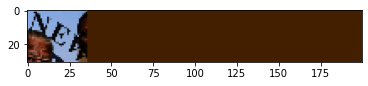

In [121]:
image, text = next(training_image_gen)
print('text:', text)
_ = plt.imshow(image)


Now we can run training.

In [125]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=100, restore_best_weights=False),
    tf.keras.callbacks.ModelCheckpoint('recognizer_ctw2.h5', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.CSVLogger('recognizer_ctw2.csv')
]
recognizer.training_model.fit_generator(
    generator=training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=200,
)

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


740/740 [==============================] - 83s 101ms/step - loss: 19.2185 - val_loss: 17.7803
Epoch 2/200
740/740 [==============================] - 74s 100ms/step - loss: 16.5294 - val_loss: 17.5392
Epoch 3/200
740/740 [==============================] - 75s 101ms/step - loss: 15.1002 - val_loss: 16.2487
Epoch 4/200
740/740 [==============================] - 74s 100ms/step - loss: 13.6474 - val_loss: 16.0579
Epoch 5/200
740/740 [==============================] - 74s 100ms/step - loss: 13.1634 - val_loss: 15.8567
Epoch 6/200
740/740 [==============================] - 75s 102ms/step - loss: 12.2384 - val_loss: 14.5967
Epoch 7/200
740/740 [==============================] - 74s 101ms/step - loss: 10.9980 - val_loss: 14.4658
Epoch 8/200
740/740 [==============================] - 74s 101ms/step - loss: 10.4834 - val_loss: 14.2612
Epoch 9/200
740/740 [==============================] - 74s 100ms/step - loss: 10.0216 - val_loss: 14.8033
Epoch 10/200
740/740 [==============================] - 75

Finally, run inference on a test sample.

Predicted: noolvidestufotodeprimeracomunion, Actual: no olvides tu foto de primera comunion


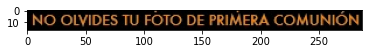

In [133]:
image_filepath, _, actual = train_labels[1]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

In [88]:
recognizer.model.load_weights('recognizer_ctw.h5')

Predicted: southwarkcathedral, Actual: southwark cathedral


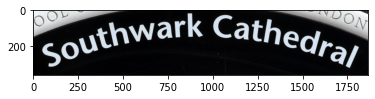

In [144]:
image_filepath, _, actual = train_labels[1398]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))